<a href="https://colab.research.google.com/github/Paulsob/TelecomLabs/blob/main/Lab06_telecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Упражнение 6

In [ ]:
import os
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [ ]:
from thinkdsp import normalize, unbias, read_wave, PinkNoise, decorate, UncorrelatedGaussianNoise, Spectrum, Spectrogram, Wave, Noise, PI2, Dct
from scipy.stats import linregress
from scipy.fftpack import dct

import numpy as np
import matplotlib.pyplot as plt

## Упражнение 6.1

Автор учебника утверждает, что функция **`analyze1`** имеет временную сложность $O(n^3)$, а функция **`analyze2`** — $O(n^2)$.  
Давайте проверим это на практике.


Объявим нужные функции.

In [ ]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [ ]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = M.dot(ys) / 2
    return amps

Сгенерируем UG-шум.

In [ ]:
ug_signal = UncorrelatedGaussianNoise()
ug = ug_signal.make_wave(duration=1, framerate=10000)

Напишем функцию для измерения времени выполнения заданной функции при различных значениях параметра.

- **`ns`** — массив, содержащий различные значения **`N`**.
- **`func`** — целевая функция, время работы которой необходимо измерить.


In [ ]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = ug.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)

    bests = [result.best for result in results]
    return bests

Также создадим функцию для построения графика зависимости времени выполнения целевой функции от количества параметров в логарифмическом масштабе.  
Эта функция будет вычислять наклон полученной прямой с помощью линейной регрессии, что позволит оценить асимптотику работы функции.

In [ ]:
def plot_bests(ns, bests):
    plt.plot(ns, bests)
    decorate(xscale='log', yscale='log')

    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x, y)
    slope = t[0]

    return slope

Зададим массив `ns`, общий для всех тестов:

In [ ]:
ns = 2 ** np.arange(5, 14)
ns

array([  32,   64,  128,  256,  512, 1024, 2048, 4096, 8192])

### 6.1.1. Функция `analyze1`

In [ ]:
bests1 = run_speed_test(ns, analyze1)

32
24.4 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
64
62.6 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
233 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
1.03 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
7.34 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
42.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
252 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
1.56 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192
9.99 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


np.float64(2.39890189294801)

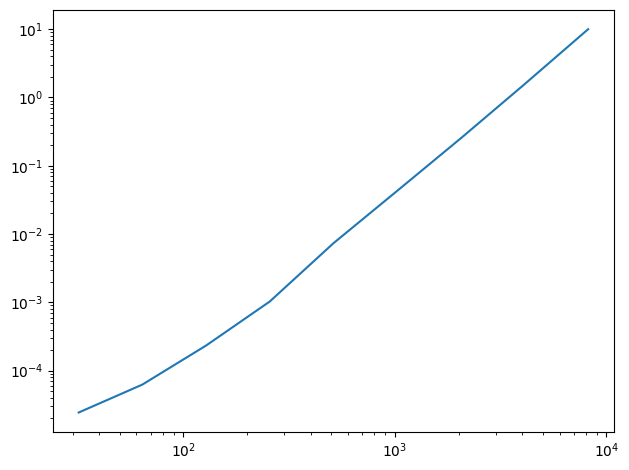

In [ ]:
plot_bests(ns, bests1)

Наклон полученной прямой составил **2.32**. Это значение указывает на то, что временная асимптотическая сложность алгоритма действительно превышает $O(n^2)$. Однако на рассмотренных выборках данных сложность алгоритма оказывается ближе к $O(n^2)$, чем к $O(n^3)$, что может быть связано с особенностями конкретных данных или реализации алгоритма.


### 6.1.2. Функция `analyze2`

In [ ]:
bests2 = run_speed_test(ns, analyze2)

32
12.3 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
64
32.5 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
114 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
256
415 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
2.96 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
17.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
78.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
276 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192
1.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


np.float64(2.1455065618724243)

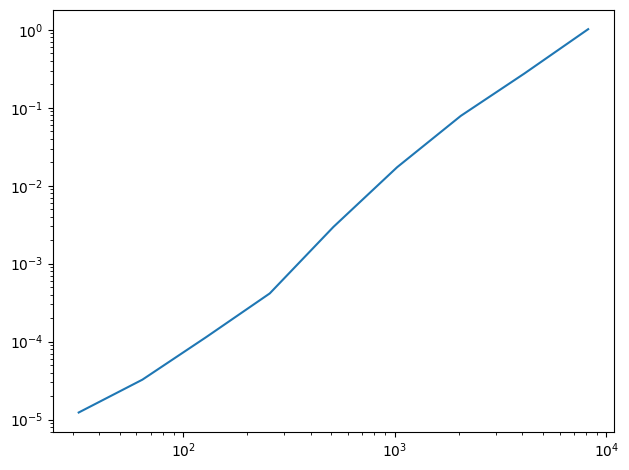

In [ ]:
plot_bests(ns, bests2)

В данном случае получено значение наклона **1.99**, что близко к заявленной сложности алгоритма $O(n^2)$.


Поупражняемся также с функциями `dct_iv` и `scipy.fftpack.dct`.

Объявим функцию `dct_iv`.

In [ ]:
def dct_iv(ys):
    N = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Добавим функции-обертки для `dct_iv` и `dct`, чтобы не писать новые тестирующие функции.

In [ ]:
def dct_iv_wrapper(ys, fs, ts):
    return dct_iv(ys)

def dct_wrapper(ys, fs, ts):
    return dct(ys)

### 6.1.3. Функция `dct_iv`

In [ ]:
bests3 = run_speed_test(ns, dct_iv_wrapper)

32
17.7 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
64
38.4 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
118 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
256
417 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
3.42 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
17 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
75.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
269 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192
1.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


np.float64(2.0924039815424016)

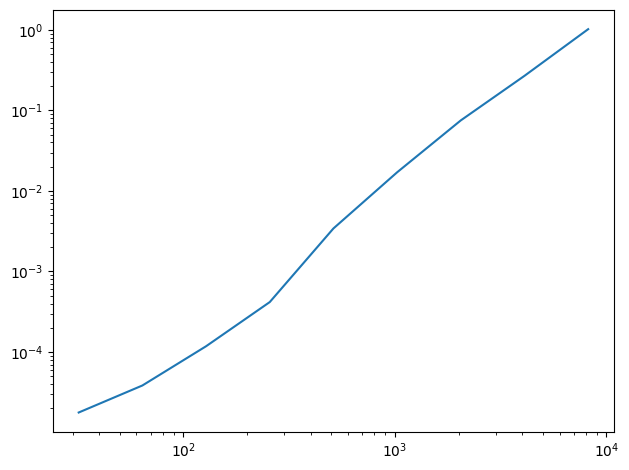

In [ ]:
plot_bests(ns, bests3)

Получено, что временная сложность алгоритма **`dct_iv`** составляет $O(n^2)$.


### 6.1.4. Функция `scipy.fftpack.dct`

In [ ]:
bests4 = run_speed_test(ns, dct_wrapper)

32
4.18 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
64
4.43 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
128
4.71 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
256
5.01 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
512
6.07 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
1024
8.02 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
2048
12.5 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
4096
21.2 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
8192
47.6 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


np.float64(0.4051371851110085)

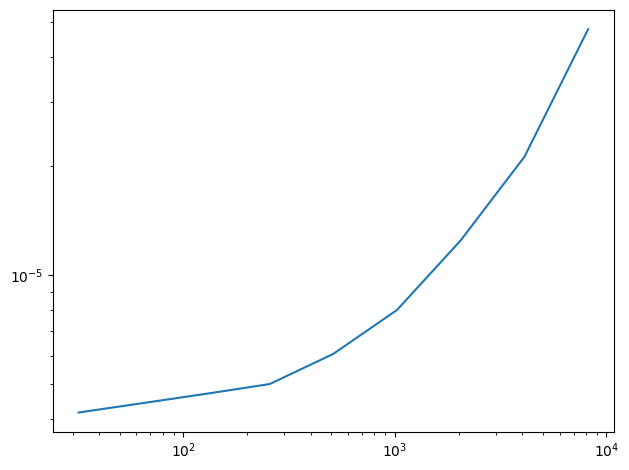

In [ ]:
plot_bests(ns, bests4)

Сложность алгоритма **`scipy.fftpack.dct`** не выражается в виде $O(n^k)$, однако, вероятно, она меньше, чем у всех ранее рассмотренных функций.

## Упражнение 6.2

Реализуем алгоритм сжатия звука на основе дискретного косинусного преобразования (ДКП).  
Для этого будем обрабатывать небольшие сегменты записи, удаляя частотные компоненты, амплитуда которых слишком низка и которые почти не слышны.

Для примера воспользуемся записью саксофона, использованной ранее.

In [ ]:
wave = read_wave('./audio/violin.wav')
wave.make_audio()

Возьмем небольшой сегмент записи.

In [ ]:
segment = wave.segment(start=1, duration=0.5)
segment.normalize()
segment.make_audio()

Получим ДКП сегмента:

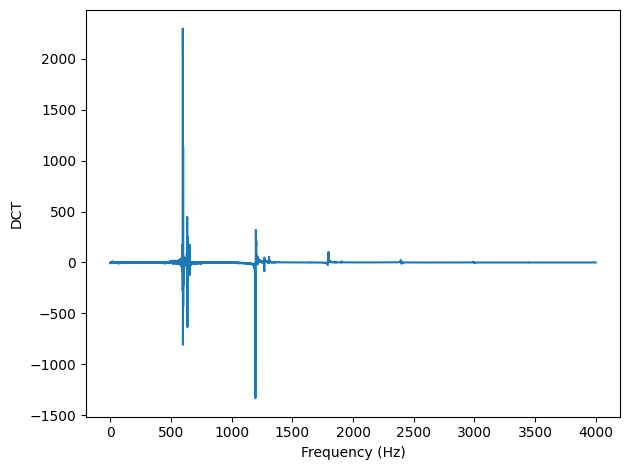

In [ ]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Напишем функцию, которая принимает ДКП сигнала и зануляет все элементы, меньшие некоторого порогового значения.

In [ ]:
def compress(dct: Dct, threshold: np.int64):
    cnt = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < threshold:
            dct.hs[i] = 0
            cnt += 1
    n = len(dct.amps)
    print(f'{(cnt / n * 100):.2f}% of entries eliminated.')

Применим её на полученном ДКП.

96.09% of entries eliminated.


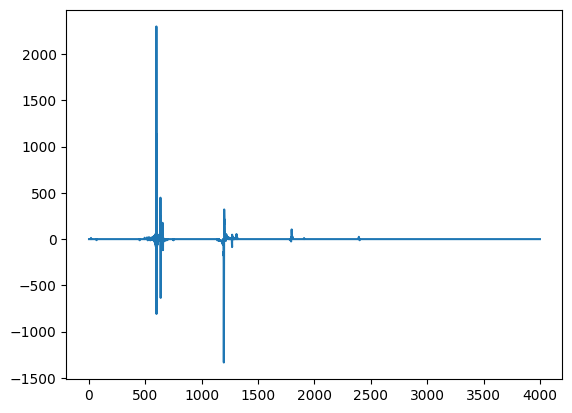

In [ ]:
seg_dct = segment.make_dct()
compress(seg_dct, threshold=10)
seg_dct.plot(high=4000)

Прослушаем результат. Он звучит примерно так же, как исходный сегмент.

In [ ]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Теперь попробуем удалить больше элементов.

In [ ]:
dct = wave.segment(start=1, duration=0.5).make_dct()
compress(dct, threshold=400)
dct.make_wave().make_audio()

99.90% of entries eliminated.


С удалением почти всех частотных компонентов (в процентном соотношении) всё ещё можно различить тембр саксофона и звучащую ноту, однако качество звука заметно ухудшилось. Тем не менее, такая высокая степень сжатия может быть полезна в ситуациях, где экономия памяти критична, а сохранение качества записи менее важно.


Итак, наш алгоритм работает для отдельного сегмента. Чтобы применить его ко всему аудиофайлу, создадим ДКП-спектрограмму, аналогичную методу **`make_spectrogram`**.


In [ ]:
def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Создадим ДКП-спектрограмму на основе объекта **`wave`** и применим функцию **`compress`** к каждому элементу спектрограммы для сжатия сигнала.


In [ ]:
dcp_sp = make_dct_spectrogram(wave, 1024)
for _, dct in dcp_sp.spec_map.items():
    compress(dct, threshold=0.2)

100.00% of entries eliminated.
97.75% of entries eliminated.
95.12% of entries eliminated.
93.26% of entries eliminated.
91.89% of entries eliminated.
93.85% of entries eliminated.
93.16% of entries eliminated.
93.55% of entries eliminated.
93.55% of entries eliminated.
94.14% of entries eliminated.
91.80% of entries eliminated.
86.52% of entries eliminated.
86.23% of entries eliminated.
85.35% of entries eliminated.
82.62% of entries eliminated.
82.91% of entries eliminated.
80.27% of entries eliminated.
78.12% of entries eliminated.
78.32% of entries eliminated.
78.12% of entries eliminated.
77.44% of entries eliminated.
73.44% of entries eliminated.
78.03% of entries eliminated.
75.00% of entries eliminated.
79.30% of entries eliminated.
78.12% of entries eliminated.
78.03% of entries eliminated.
78.81% of entries eliminated.
74.90% of entries eliminated.
76.07% of entries eliminated.
73.73% of entries eliminated.
76.95% of entries eliminated.
74.32% of entries eliminated.
78.81% of

84.08% of entries eliminated.
86.04% of entries eliminated.
86.13% of entries eliminated.
85.35% of entries eliminated.
85.45% of entries eliminated.
84.57% of entries eliminated.
84.96% of entries eliminated.
86.23% of entries eliminated.
84.96% of entries eliminated.
85.06% of entries eliminated.
85.64% of entries eliminated.
84.57% of entries eliminated.
85.64% of entries eliminated.
84.28% of entries eliminated.
85.25% of entries eliminated.
85.06% of entries eliminated.
86.23% of entries eliminated.
84.18% of entries eliminated.
83.30% of entries eliminated.
83.79% of entries eliminated.
83.69% of entries eliminated.
83.50% of entries eliminated.
82.71% of entries eliminated.
81.74% of entries eliminated.
83.01% of entries eliminated.
84.38% of entries eliminated.
85.84% of entries eliminated.
86.23% of entries eliminated.
85.06% of entries eliminated.
86.72% of entries eliminated.
86.04% of entries eliminated.
81.05% of entries eliminated.
84.96% of entries eliminated.
85.64% of 

96.09% of entries eliminated.
96.29% of entries eliminated.
96.39% of entries eliminated.
97.27% of entries eliminated.
97.17% of entries eliminated.
97.36% of entries eliminated.
97.56% of entries eliminated.
97.85% of entries eliminated.
97.56% of entries eliminated.
98.05% of entries eliminated.
97.85% of entries eliminated.
97.56% of entries eliminated.
97.66% of entries eliminated.
98.34% of entries eliminated.
98.63% of entries eliminated.
98.83% of entries eliminated.
98.05% of entries eliminated.
97.66% of entries eliminated.
98.44% of entries eliminated.
98.14% of entries eliminated.
98.73% of entries eliminated.
98.73% of entries eliminated.
98.54% of entries eliminated.
98.14% of entries eliminated.
98.34% of entries eliminated.
98.63% of entries eliminated.
98.63% of entries eliminated.
98.14% of entries eliminated.
98.44% of entries eliminated.
98.83% of entries eliminated.
98.54% of entries eliminated.
98.83% of entries eliminated.
98.93% of entries eliminated.
98.63% of 

Преобразуем ДКП-спектрограмму обратно в объект **`Wave`**. В результате получим сжатый аудиофайл, который звучит почти так же, как оригинальный.

In [ ]:
dcp_sp.make_wave().make_audio()

## Упражнение 6.3

В блокноте **`phase.ipynb`** автор исследует влияние фазы на восприятие звука. Повторим аналогичные эксперименты, используя другой сегмент звука.

Объявим необходимые для работы функции.

In [ ]:
def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase (radian)')

def plot_three(spectrum, thresh=1):
    """Plot amplitude, phase, and waveform.

    spectrum: Spectrum object
    thresh: threshold passed to plot_angle
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

Считаем аудиофайл.

In [ ]:
wave = read_wave('./audio/thisk.wav')
wave.make_audio()

Возьмем небольшой сегмент.

In [ ]:
segment = wave.segment(start=4.1, duration=0.9)

Получим аудио, а также визуализируем амплитуды, углы и форму сигнала.

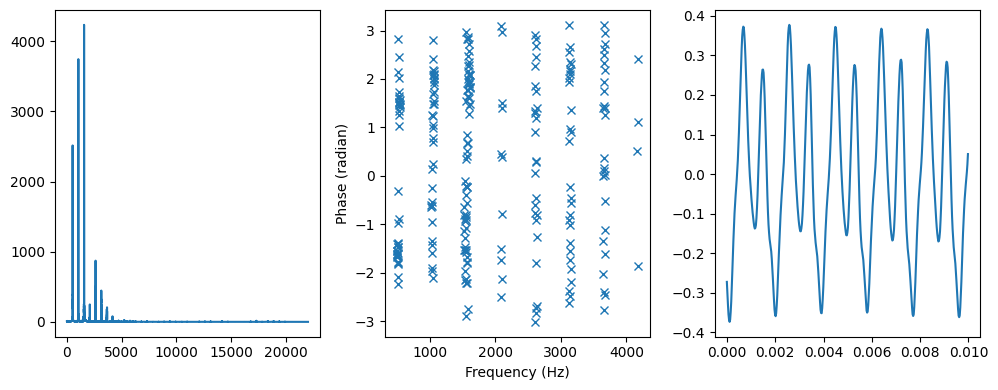

In [ ]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Сделаем все углы равными нулю.

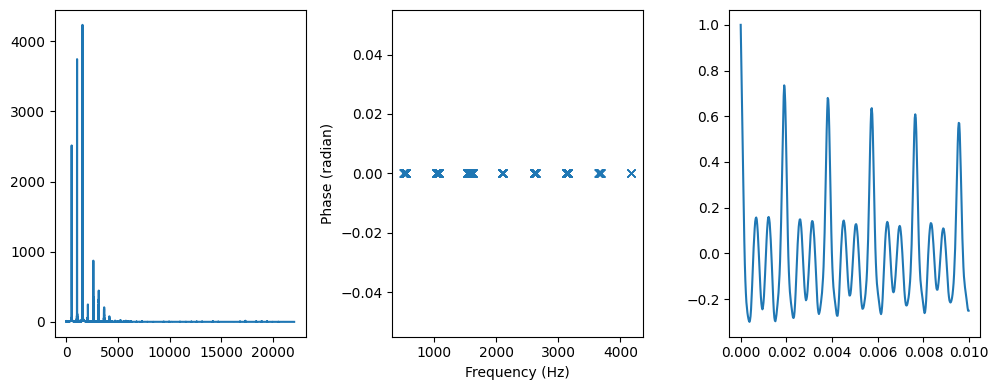

In [ ]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Заметим, что теперь сегмент звучит так, будто амплитуда периодически то возрастает, то уменьшается.

Повернем углы на 2 радиана.

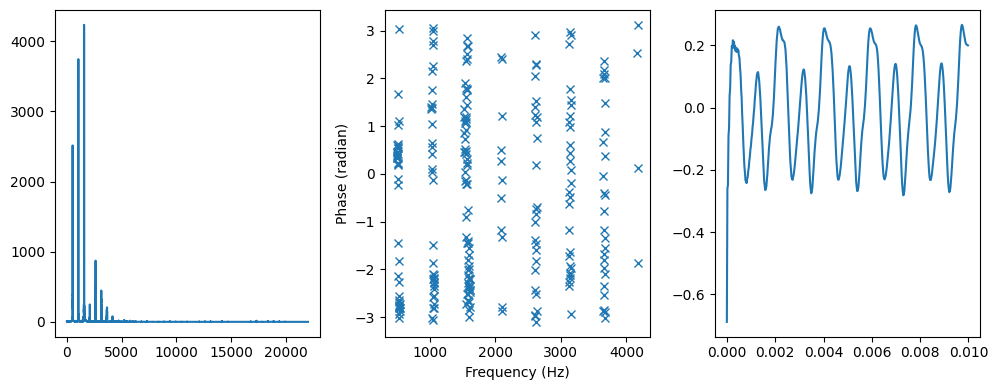

In [ ]:
spectrum3 = rotate_angle(spectrum, 2)
plot_three(spectrum3, thresh=50)

Аудиофайл звучит примерно так же.

Рандомизируем углы.

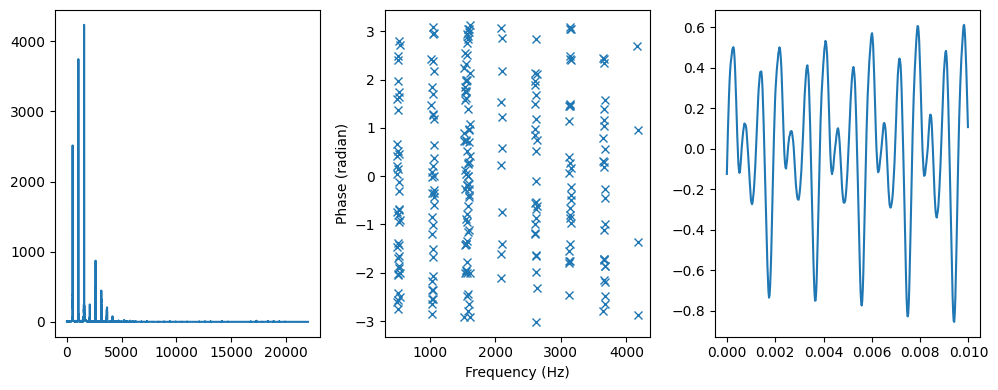

In [ ]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Полученный эффект на слух похож на тот, что происходит, когда мы зануляем углы.